EE364b Convex Optimization II, S. Boyd

Written by Shuvomoy Das Gupta

-------------------

We want to solve the dual of the following problem using projected subgradient method:

$$
\begin{align}
& \text{minimize} \quad \frac{1}{2} x^T P x-q^T x\\
& \text{subject to} \quad x_i^2 \leq 1, \quad \forall i \in \{1,2,\ldots,n\}, 
\end{align}
$$
where, $P$ is a positive definite matrix.


In [17]:
# Data generation
n=50
A=randn(n,n)
P= A*A' # Enforcing Cholesky decomposition thus making P positive definite
eigsP=eigvals(P)
println("P is a positive definite matrix with max eigenvalue ", maximum(eigsP), "and minimumeigen value ", minimum(eigsP))
q=randn(n,1)


P is a positive definite matrix with max eigenvalue 178.84104018019272and minimumeigen value 0.00933233818688372


50x1 Array{Float64,2}:
 -0.692911 
 -0.693214 
  0.54531  
  0.416912 
  1.39434  
 -0.660448 
  1.45572  
 -0.0675312
  0.865284 
  1.16167  
  0.0773813
  0.209437 
  0.668412 
  ⋮        
  0.866414 
  0.868649 
  0.764416 
 -1.00148  
 -0.79016  
 -0.171691 
 -0.41118  
  0.297769 
  1.93076  
 -0.190517 
 -1.48792  
 -0.458384 

Solving the problem using `Convex.jl`

In [18]:
# Solve the problem using Convex.jl
using Convex

using SCS

x̄=Variable(n)

obj=(0.5*quad_form(x̄, P))- dot(q,x̄)# quad_form(α, M):=αᵀMα in Convex
# For a detailed list of suppored operations see http://convexjl.readthedocs.org/en/latest/operations.html

constraints=[]# Declaring an empty vecotr of constraints first

# Let us add the constraints x[i]^2 in a loop...
for i in 1:n
  constraints += (x̄[i]^2 <= 1)
end

# Define the problem in
problem=
minimize( obj,
# subject to
constraints
)

# Let's solve it:
solve!(problem,SCSSolver())

# Let's look at the output

print("The status of the solution is ", problem.status)

xMinValue=x̄.value
fMinValue=problem.optval

println( "\nwith optimal objective value, f(x*)=", fMinValue,
"\noptimal solution is x*=", xMinValue)


The status of the solution is Optimal
with optimal objective value, f(x*)=-2.740830704795274
optimal solution is x*=[0.0721469016972509
 -0.8034884359868771
 0.6955631686140948
 0.5018896531365743
 1.000001397256563
 0.17682216214224755
 -0.09508183616216097
 0.5148847955566436
 -0.07367958509431677
 0.3060048611899143
 -0.5393575531009634
 0.5320253693473066
 1.0000000065614478
 -0.02738016319913205
 0.5365366181998897
 0.409075586685549
 -0.2658330422923584
 0.5623390705805256
 0.20805397515049648
 0.4595931018140705
 0.24355271082743532
 0.3633071190774586
 -0.6895380349200072
 -0.4362529280895515
 0.4444053144522189
 -0.2656089263942655
 0.18882791367005897
 -0.5411489749894567
 0.09135917102448775
 -0.7743209344313751
 -0.47614590455076067
 0.3912200983017153
 0.37371641411370654
 -0.09365558937292752
 -0.4261857832402042
 -0.29021684543164294
 -0.2778352950875476
 -0.3597732995657049
 -0.329612386373405
 -0.021984684966868208
 0.43328534009231007
 0.34130774128345426
 -0.99999995

Applying the projected subgradient method for the primal problem

In [19]:
# Projected subgradient algorithm for primal problem
println("Projected subgradient algorithm for primal problem")

fPrmlSet=Float64[] # We are creating an empty array where we will store the primal objective values as we progress
push!(fPrmlSet,Inf) # Intial value of fPrimal is infinity

fPrmlBest=Float64[] # It is an array where the last element will give f_best^{(k)} so far for the primal objective
push!(fPrmlBest, Inf) # Intial best value of fPrimal is infinity
x=zeros(n,1) # intial starting point is taken to be zero

k=1 # k is the iteration counter, starting at 1

maxIter = 3000 # Maximum number of iterations

while(k < maxIter)

# Evaluate primal objective value
fKval=((0.5*x'*P*x)-q'*x)[1,1]# Julia treats the quantity as 1x1 matrix, so I am taking the [1,1] th element the number itself!

# Calculating the subgradient for the primal function which is essentially the gradient
gK=(P*x)-q

# Step size selcetion: Consider Polyak's step size
#αK=(fKval-fMinValue)/norm(gK)^2
#αK=0.001
αK=1/k

# Push the current value of f(x^(k)) in fSet
push!(fPrmlSet,fKval)

# Note how we are pushing the best f primal found so far in the last element of f
push!(fPrmlBest, min(fPrmlBest[end],fKval))

# Projected subgradient alg
x=x-αK*gK # Find the subgradient update
x=max(min(x,1),-1) # Project it on the set {x: ∀i xᵢ²<=1}
# min(x,1) compares each element of x with 1 and takes the minimum, and max(x,-1)  compares each element of x with -1 and takes the maximum
k=k+1
end # while

Projected subgradient algorithm for primal problem


Applying projected subgradient algorithm for dual problem

In [20]:
#Subgradient method for the dual problem
println("Subgradient method applied to the dual problem")

gDualSet=Float64[]

push!(gDualSet,-Inf)

gDualBest=Float64[]

push!(gDualBest,-Inf)

λ=ones(n)# Initial dual variable

k=1 # Iteration counter

while (k < maxIter)
# Calculating subgradient
# Calculating x^{(k)}
xStar=inv(P+diagm(vec(2*λ)))*q
#xStar=max(min(xStar,1),-1)
h=xStar.^2-1

# Calculating dual objective value
gKval=(-0.5*q'*xStar-sum(λ))[1,1]
push!(gDualSet,gKval)

push!(gDualBest, max(gKval,gDualBest[end]))
# Calculating primal objective value

# step size selection
sK=1/k

λ=max(0,λ+sK*h)

k=k+1
end


Subgradient method applied to the dual problem


Let's plot how both of the projected subgradient methods work

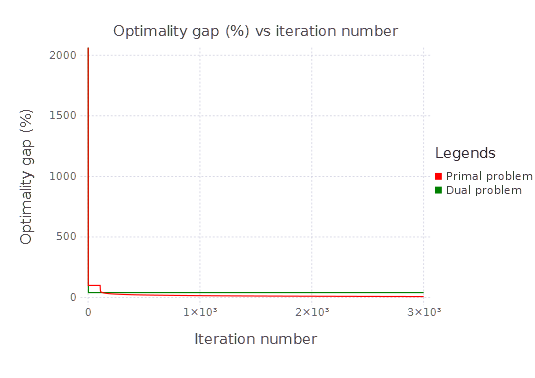

In [21]:
using Gadfly

curvePrimal=abs((fPrmlBest-fMinValue)/(fMinValue))*100
curveDual=abs((gDualBest-fMinValue)/fMinValue)*100

iters=1:maxIter
plot(
  layer(x=iters,y=curvePrimal,Geom.line, Theme(default_color=color("red"))),
        layer(x=iters, y=curveDual,Geom.line,Theme(default_color=color("green"))),
  Guide.manual_color_key("Legends", ["Primal problem","Dual problem"], 
[color("red"),color("green")]),
Guide.ylabel("Optimality gap (%)"), # label for y-axis
Guide.xlabel("Iteration number"),  # label for x-axis
Guide.title("Optimality gap (%) vs iteration number")
)